# Semantic segmentation

In this notebook we will show how to visualize and use our pixel-perfect segmentation modality. To read more about this modality check out our documentation - https://docs.datagen.tech/en/latest/Modalities/semantic_segmentation.html

## Imports

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import cv2

import sys

import datagen
from dghelpers import imshow

## Creation of a Dataset container

In [144]:
DATASET_PATH= '../resources/faces_1'
ds = datagen.load(DATASET_PATH)
dp= ds[5]

## Segmentation visualization

Text(0.5, 1.0, 'Segmentation map')

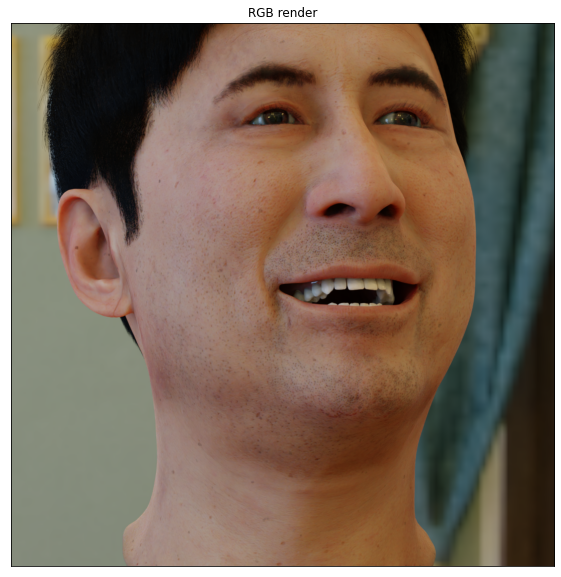

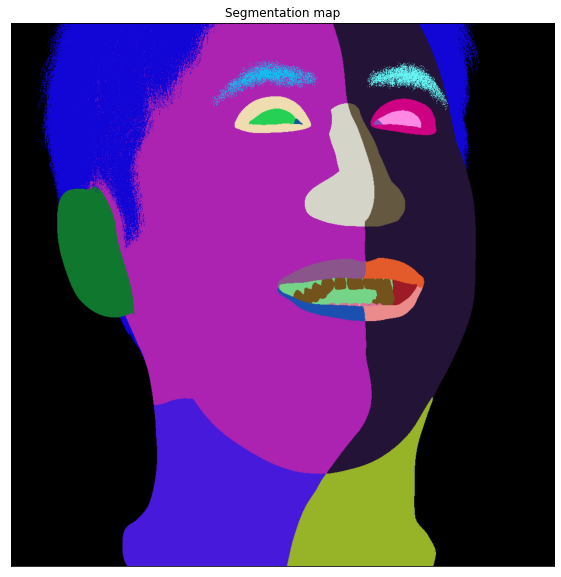

In [145]:
imshow(dp.visible_spectrum)
plt.title('RGB render')

#The segmentation map is 16 bit. It has to be normalized to be displayed
imshow((dp.semantic_segmentation/256).astype(np.uint8))
plt.title('Segmentation map')

## Background replacement
We'll remove the original background from the image using the segmentation map and replace it with a new random background

Let's load the new background and crop it to the render size

In [146]:
random_background = plt.imread('../docs/assets/random_background.jpg')
random_background = PIL.Image.fromarray(random_background).crop(box=(0, 0, dp.visible_spectrum.shape[0], dp.visible_spectrum.shape[1]))
random_background = np.asarray(random_background)

Create a background mask using the segementation colormap

Text(0.5, 1.0, 'Background mask')

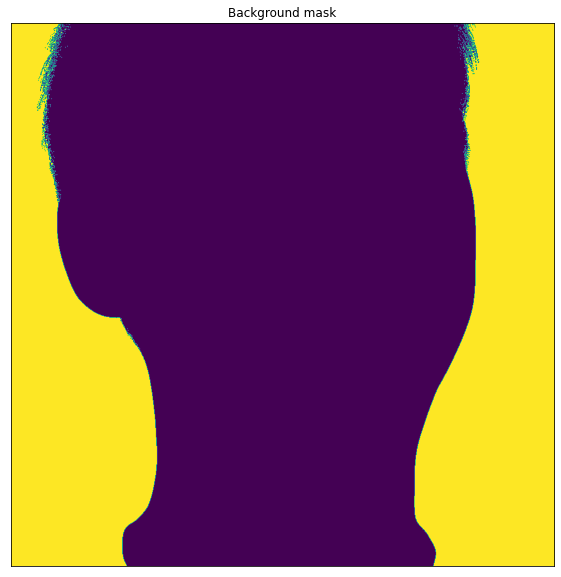

In [147]:
background_mask = np.logical_and.reduce(dp.semantic_segmentation == dp.semantic_segmentation_metadata.background, axis=2)
imshow(background_mask.astype('float'))
plt.title('Background mask')

Now replace the background pixels from the render with the new background's pixels

Text(0.5, 1.0, 'Rgb render with the new background')

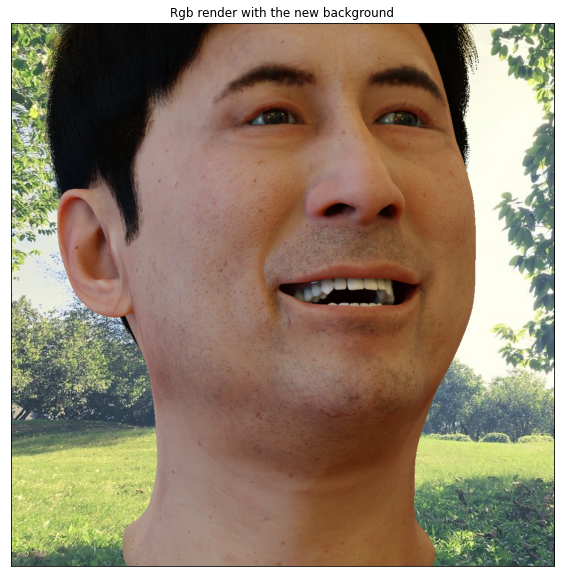

In [148]:
rgb_new_background = dp.visible_spectrum.copy()
rgb_new_background[background_mask] = np.asarray(random_background)[background_mask]

imshow(rgb_new_background)
plt.title('Rgb render with the new background')

## Segment extraction
This part explains how to extract different segments from the segmentation map


A segment's color map can be accessed using:

In [149]:
print(f'Left eyebrow segment RGB code = {dp.semantic_segmentation_metadata.human.head.eyebrow.left}')

Left eyebrow segment RGB code = [25890 62289 62077]


Let's extract the nose from the picture using the segmentation map. <br>
To perform this task, we have to unify the nose's left and right segments into a single mask...

In [150]:
nose_colormap = dp.semantic_segmentation_metadata.human.head.nose
seg_mask = np.logical_or(dp.semantic_segmentation == nose_colormap.left, dp.semantic_segmentation == nose_colormap.right).all(axis=-1)
seg_mask = np.broadcast_to(seg_mask[..., np.newaxis], dp.visible_spectrum.shape)
print(nose_colormap.left)
print(nose_colormap.right)

[25984 22567 16578]
[54652 54478 51619]


... and apply the mask to the render

Text(0.5, 1.0, 'Nose segmentation')

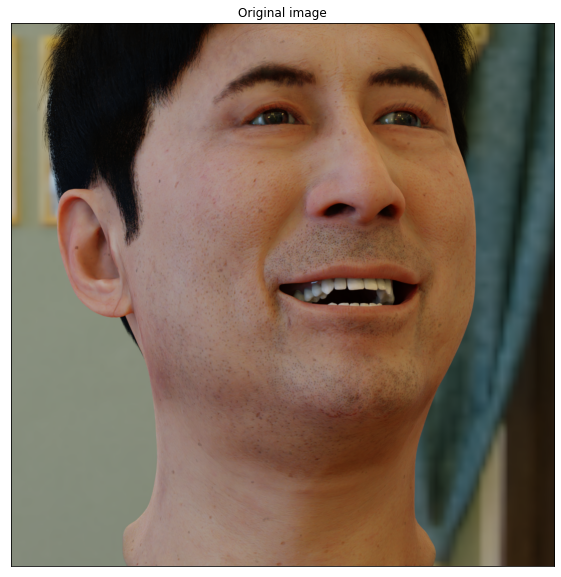

<Figure size 432x288 with 0 Axes>

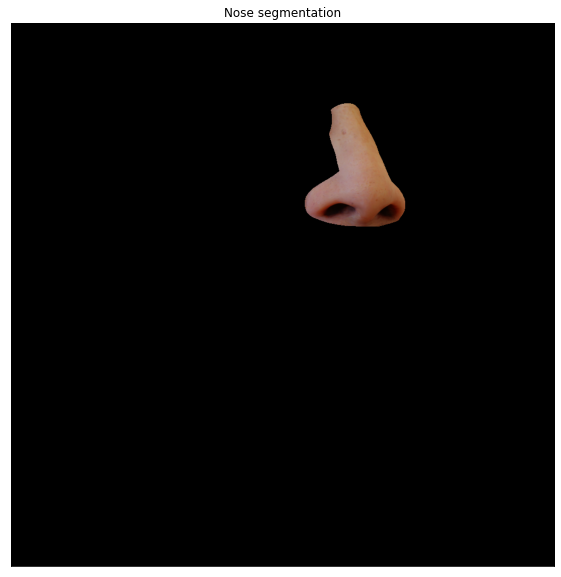

In [151]:
segment_img = dp.visible_spectrum.copy()
segment_img[~seg_mask] = 0

imshow(dp.visible_spectrum)
plt.title('Original image')
plt.figure()
imshow(segment_img)
plt.title('Nose segmentation')

## Iris and Pupil segmentation
For the eyes, we currently provide only eyeball segmentation. Iris and pupil segmentation don't come out of the box yet. <br>
This information can be easily extracted from the eyes keypoints. Let us show you how... <br><br>
We'll begin by building a function to fit an ellipse to a set of keypoints:

In [152]:
from skimage.measure import EllipseModel
from matplotlib.patches import Patch

def get_ellipse_mask(ellipse_keypoints, height, width):
    ell = EllipseModel()
    ell.estimate(ellipse_keypoints)
    xc, yc, a, b, theta = ell.params
    yy, xx = np.meshgrid(range(height), range(width))
    in_ellipse = ((xx - xc) / a) ** 2 + ((yy - yc) / b) ** 2 < 1
    return in_ellipse

Let's extract the iris and pupil keypoints and get the ellipse parameters for each of them

In [153]:
h, w, _ = dp.visible_spectrum.shape
irises_keypoints = dp.actor_metadata.iris_circle.coords_2d[0]
pupils_keypoints = dp.actor_metadata.pupil_circle.coords_2d[0]

right_iris_mask = get_ellipse_mask(irises_keypoints.right_eye, h, w)
left_iris_mask = get_ellipse_mask(irises_keypoints.left_eye, h, w)
right_pupil_mask = get_ellipse_mask(pupils_keypoints.right_eye, h, w)
left_pupil_mask = get_ellipse_mask(pupils_keypoints.left_eye, h, w)

We'll substract the pupil area from the iris masks

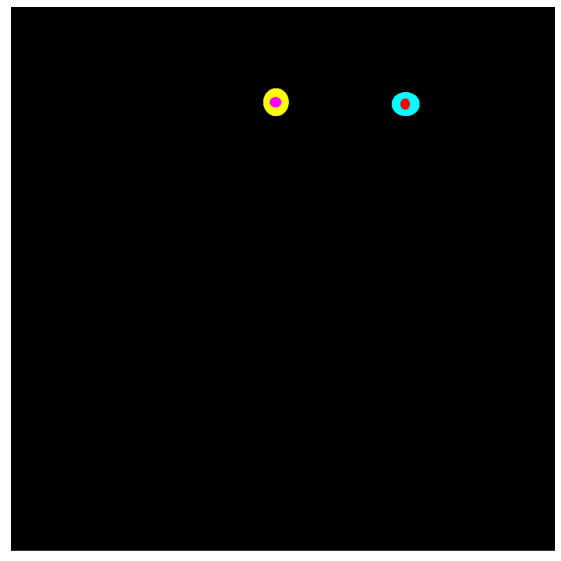

In [154]:
right_iris_mask[right_pupil_mask] = False
left_iris_mask[left_pupil_mask] = False

img = np.zeros(dp.visible_spectrum.shape, dtype=np.uint8)
img[left_pupil_mask] = np.array([[255, 0, 0]])
img[right_pupil_mask] = np.array([[255, 0, 255]])
img[left_iris_mask] = np.array([[0, 255, 255]])
img[right_iris_mask] = np.array([[255, 255, 0]])
imshow(img)

Let's use the eyeball segmentation to remove the occluded pupil and iris areas from their respective masks

Text(0.5, 1.0, 'Eyes mask')

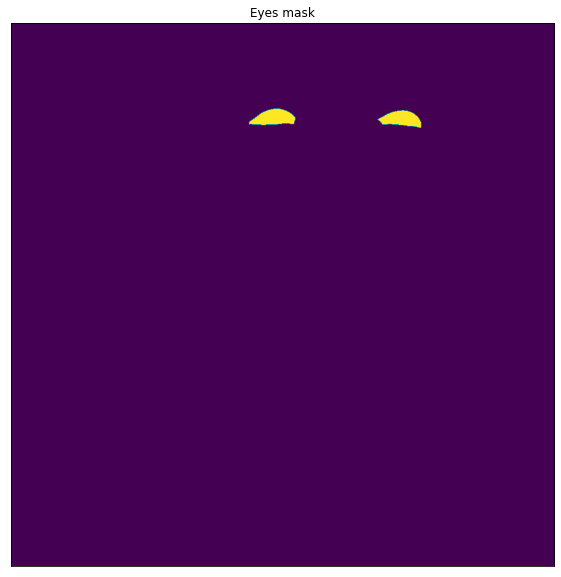

In [155]:
eye_colormap = dp.semantic_segmentation_metadata.human.head.eye
eyes_mask = (dp.semantic_segmentation == eye_colormap.left.eyeball) | (dp.semantic_segmentation == eye_colormap.right.eyeball)
eyes_mask = np.all(eyes_mask, axis=2)
imshow(eyes_mask)
plt.title('Eyes mask')

The intersection between the eyeballs and the pupils/irises gives us the required segmentation

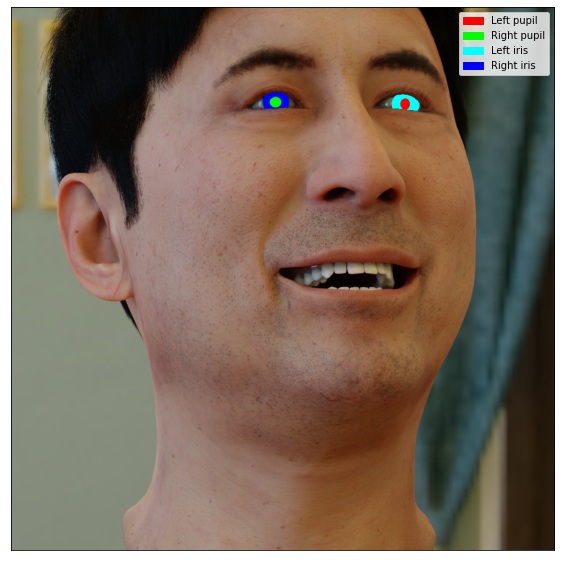

In [156]:
right_iris_mask &= eyes_mask
left_iris_mask &= eyes_mask
right_pupil_mask &= eyes_mask
left_pupil_mask &= eyes_mask

LEFT_PUPIL_COLOR = [1, 0, 0]
RIGHT_PUPIL_COLOR = [0, 1, 0]
LEFT_IRIS_COLOR = [0, 1, 1]
RIGHT_IRIS_COLOR = [0, 0, 1]

img = dp.visible_spectrum.copy()
img[left_pupil_mask] = 255 * np.array(LEFT_PUPIL_COLOR)
img[right_pupil_mask] = 255 * np.array(RIGHT_PUPIL_COLOR)
img[left_iris_mask] = 255 * np.array(LEFT_IRIS_COLOR)
img[right_iris_mask] = 255 * np.array(RIGHT_IRIS_COLOR)

imshow(img)

plt.gca().legend(handles=[Patch(color=LEFT_PUPIL_COLOR, label='Left pupil'), 
                          Patch(color=RIGHT_PUPIL_COLOR, label='Right pupil'),
                         Patch(color=LEFT_IRIS_COLOR, label='Left iris'),
                         Patch(color=RIGHT_IRIS_COLOR, label='Right iris')])